In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import math

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", valid=False, normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        
        if valid:
            idx = int(len(inputs) * .8)
            return inputs[:idx], inputs[idx:], outputs[:idx], outputs[idx:]

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        if self.split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = (self.inputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data
    
class ValidationDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, inputs, outputs, transform=None):
        super(ValidationDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = inputs, outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [143]:
batch_sz = 10  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz)

## Sample a batch of data and visualize 

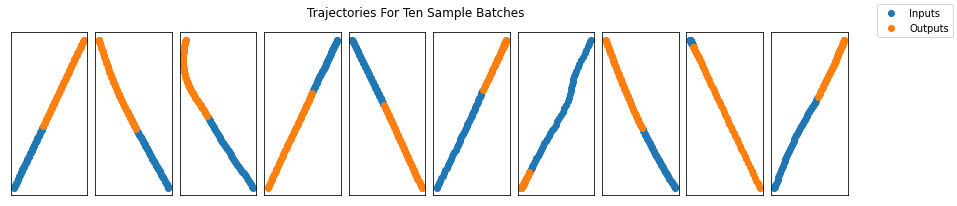

In [165]:
import matplotlib.pyplot as plt
import random

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    #axs.legend((l2, l4), ('oscillatory', 'damped'), loc='upper right', shadow=True)
    fig.subplots_adjust(hspace = .5, wspace=.1)
   
    axs = axs.ravel()   
    fig.suptitle("Trajectories For Ten Sample Batches", y=1.0)

    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        #first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        
    fig.legend(['Inputs', 'Outputs'])

        
for i_batch, sample_batch in enumerate(train_loader):
    # inp[i] is a scene with 50 coordinates, input[i, j] is a coordinate
    # gotta loop through each scene in the batch
    inp, out = sample_batch # inp: (batch size, 50, 2), out: (batch size, 60, 2)
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

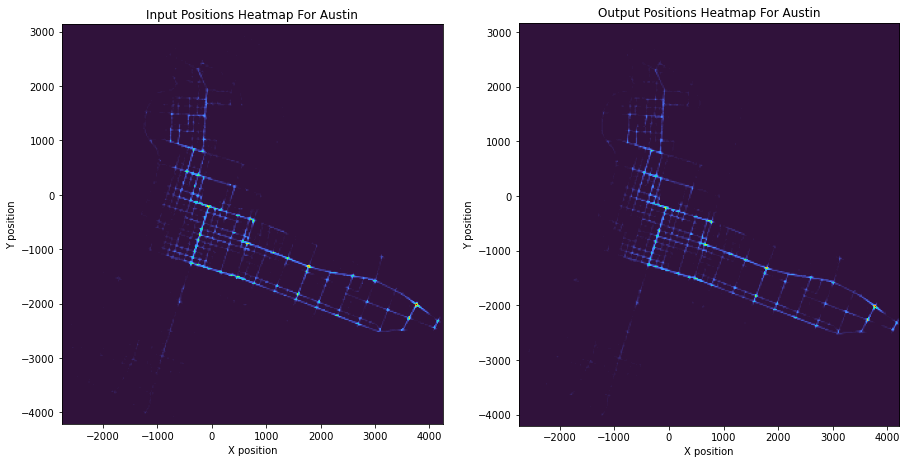

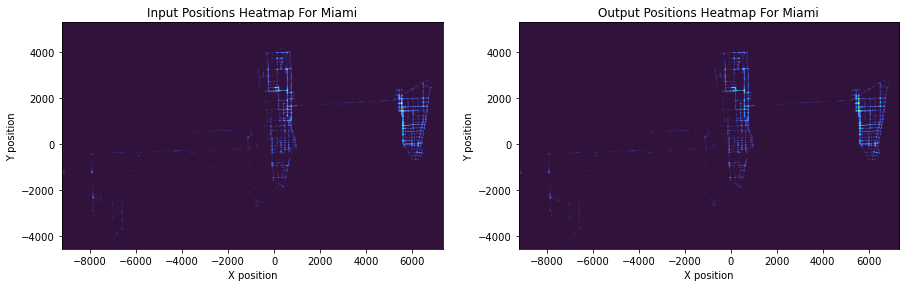

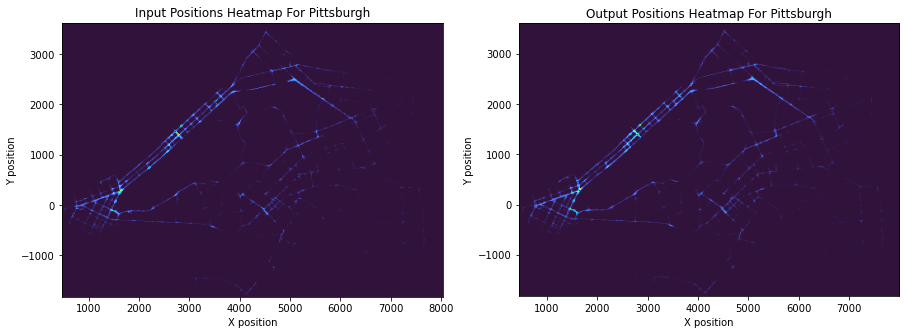

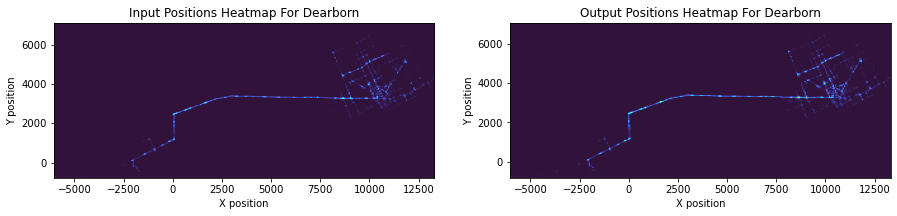

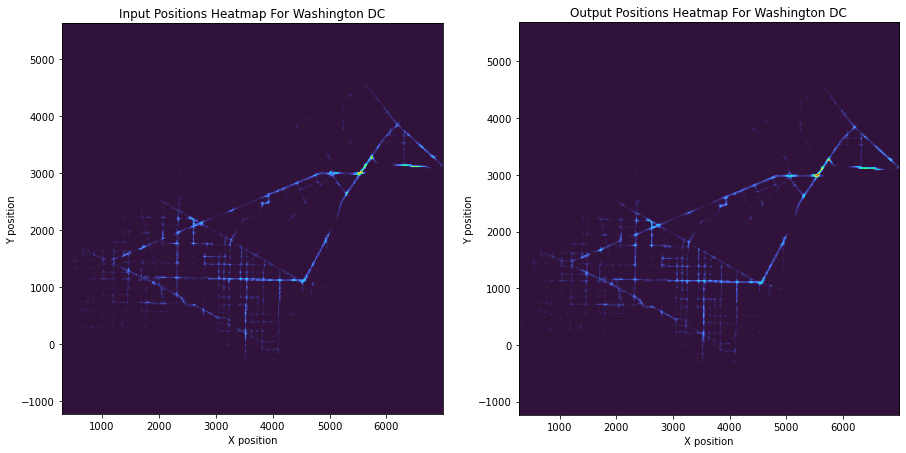

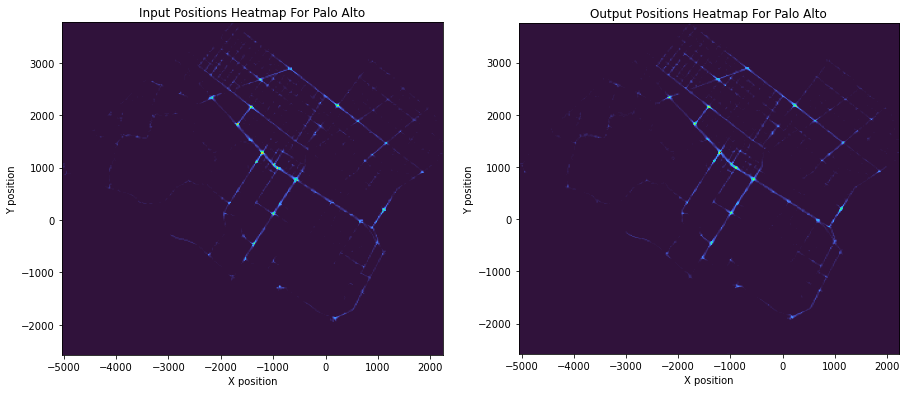

In [5]:
#source : https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr

city_names = ["Austin", "Miami", "Pittsburgh", "Dearborn", "Washington DC", "Palo Alto"]


for i, city in enumerate(cities):
    
    fig, axs = plt.subplots(ncols=2,figsize=(15, 10))
    
    inp, out = get_city_trajectories(city=city)
             
    x_in = [x.T[0] for i in inp for x in i]
    y_in = [x.T[1] for i in inp for x in i]
    x_out = [x.T[0] for i in out for x in i]
    y_out = [x.T[1] for i in out for x in i]
        
    heatmap, xedges, yedges = np.histogram2d(x_in, y_in, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    axs[0].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo)#jet
    axs[0].set_title(f'Input Positions Heatmap For {city_names[i]}')
    axs[0].set_xlabel(f'X position')
    axs[0].set_ylabel(f'Y position')
        
    heatmap, xedges, yedges = np.histogram2d(x_out, y_out, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    axs[1].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo) #jet
    axs[1].set_title(f'Output Positions Heatmap For {city_names[i]}')
    axs[1].set_xlabel(f'X position')
    axs[1].set_ylabel(f'Y position')
    
    fig.show();

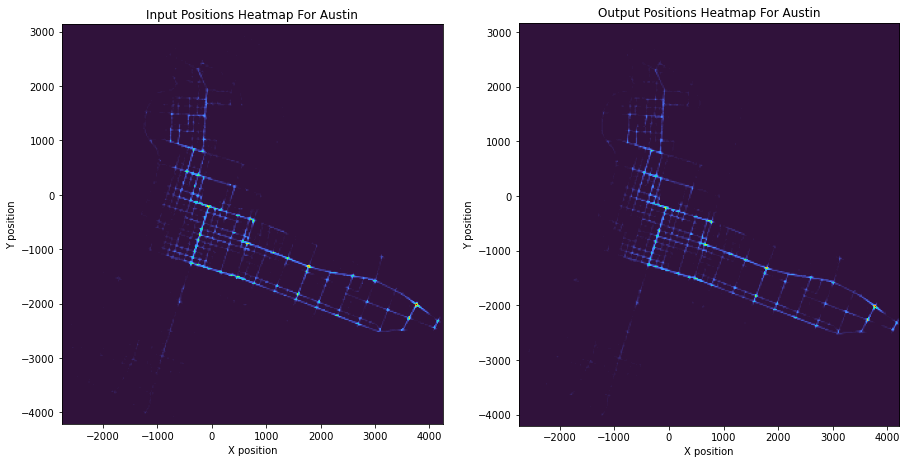

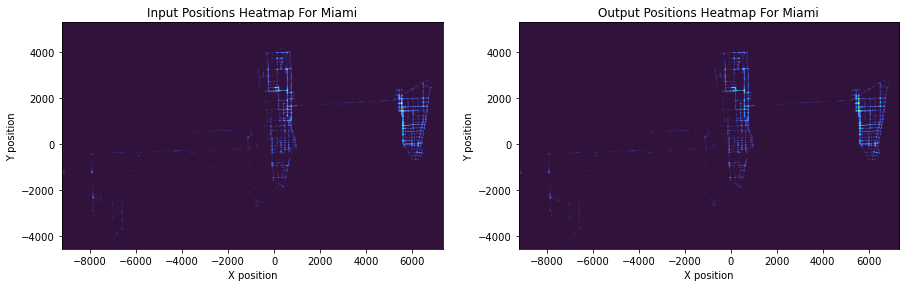

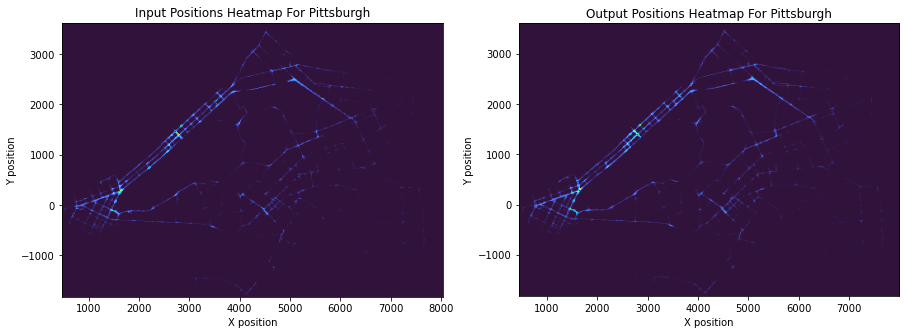

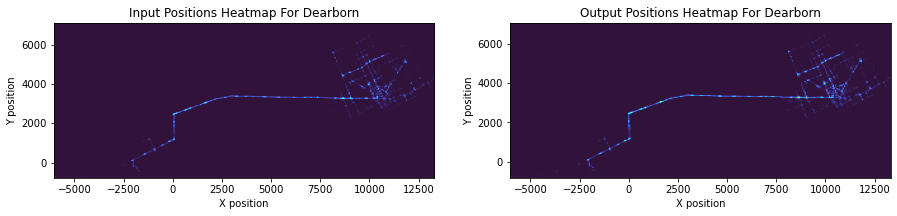

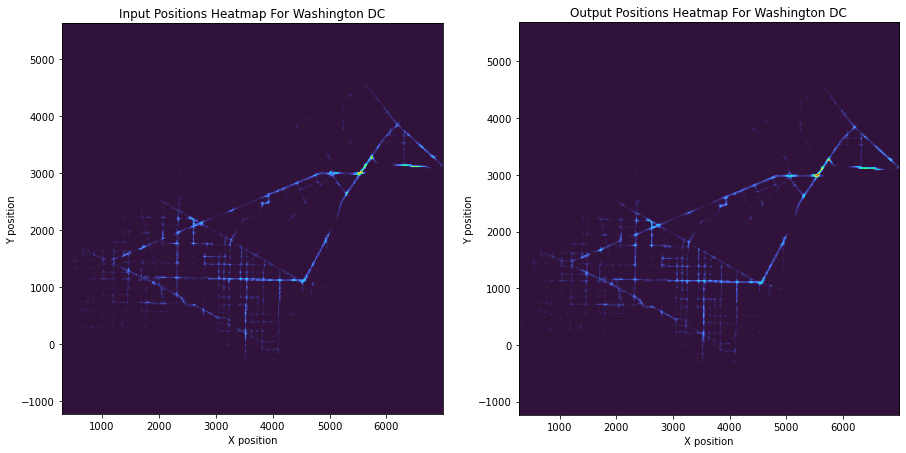

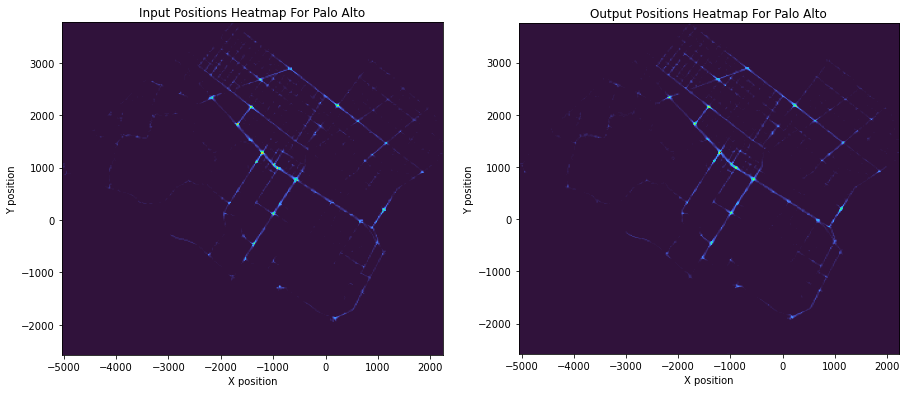

In [6]:
#source : https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr

city_names = ["Austin", "Miami", "Pittsburgh", "Dearborn", "Washington DC", "Palo Alto"]


for i, city in enumerate(cities):
    
    fig, axs = plt.subplots(ncols=2,figsize=(15, 10))
    
    inp, out = get_city_trajectories(city=city)
             
    x_in = [x.T[0] for i in inp for x in i]
    y_in = [x.T[1] for i in inp for x in i]
    x_out = [x.T[0] for i in out for x in i]
    y_out = [x.T[1] for i in out for x in i]
        
    heatmap, xedges, yedges = np.histogram2d(x_in, y_in, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    axs[0].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo)#jet
    axs[0].set_title(f'Input Positions Heatmap For {city_names[i]}')
    axs[0].set_xlabel(f'X position')
    axs[0].set_ylabel(f'Y position')
        
    heatmap, xedges, yedges = np.histogram2d(x_out, y_out, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    axs[1].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo) #jet
    axs[1].set_title(f'Output Positions Heatmap For {city_names[i]}')
    axs[1].set_xlabel(f'X position')
    axs[1].set_ylabel(f'Y position')
    
    fig.show();

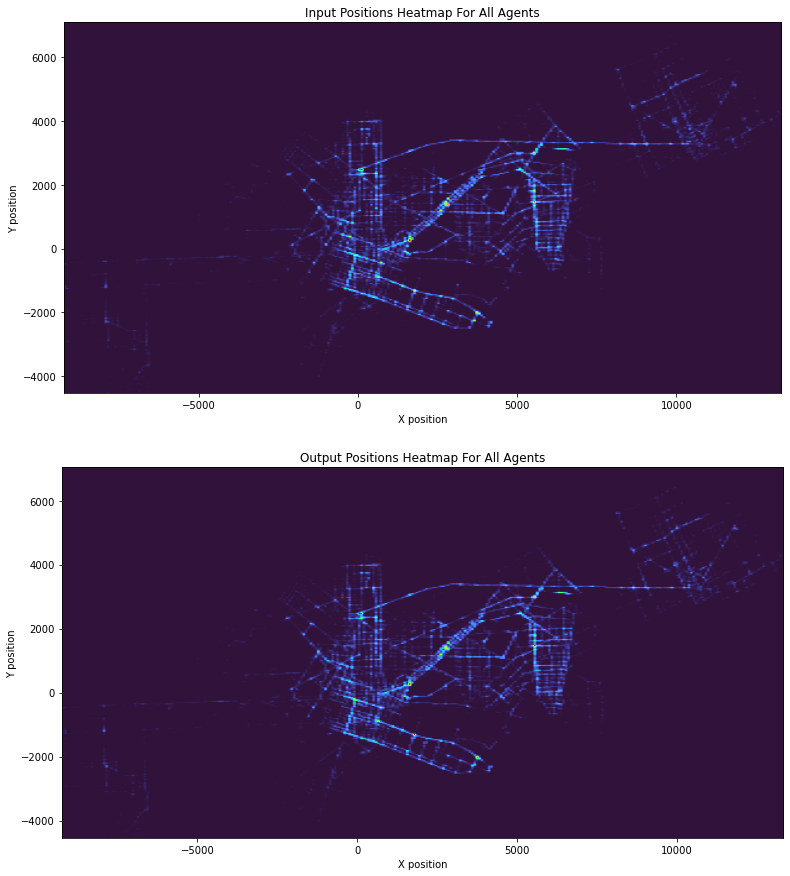

In [188]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

city = cities[0]

inp, out = get_city_trajectories(city=city)

fig, axs = plt.subplots(nrows=2,figsize=(15, 15))

for city in cities[1:]:
    
    i, o = get_city_trajectories(city=city)
    
    inp = np.concatenate((inp, i), axis=0)
    out = np.concatenate((out, o), axis=0)    
                 
x_in = [x.T[0] for i in inp for x in i]
y_in = [x.T[1] for i in inp for x in i]
x_out = [x.T[0] for i in out for x in i]
y_out = [x.T[1] for i in out for x in i]

heatmap, xedges, yedges = np.histogram2d(x_in, y_in, bins=300)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

axs[0].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo)
axs[0].set_title(f'Input Positions Heatmap For All Agents')
axs[0].set_xlabel(f'X position')
axs[0].set_ylabel(f'Y position')

heatmap, xedges, yedges = np.histogram2d(x_out, y_out, bins=300)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
axs[1].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.turbo) #jet
axs[1].set_title(f'Output Positions Heatmap For All Agents')
axs[1].set_xlabel(f'X position')
axs[1].set_ylabel(f'Y position')

fig.show();

In [8]:
#!pip install cmasher

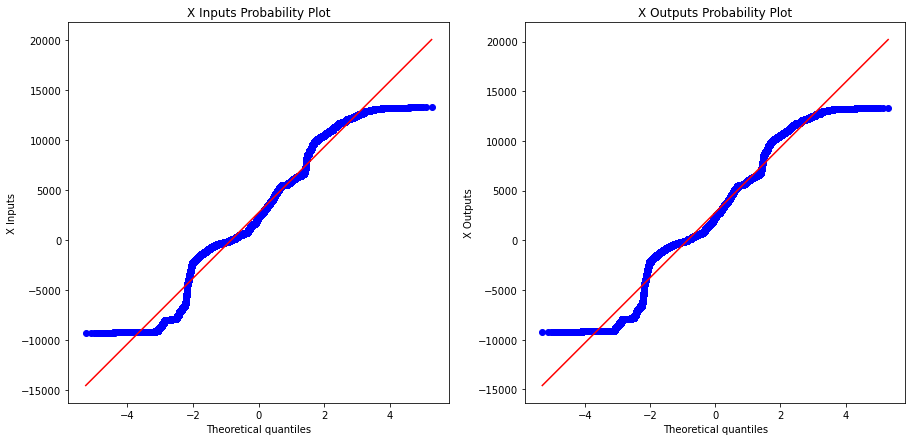

In [9]:
# import numpy as np 
import pylab 
import scipy.stats as stats

fig, axs = plt.subplots(ncols=2,figsize=(15, 7))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(x_in, dist="norm", plot=axs[0])
axs[0].set_ylabel('X Inputs')
axs[0].set_title('X Inputs Probability Plot')

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(x_out, dist="norm", plot=axs[1])
axs[1].set_ylabel('X Outputs')
axs[1].set_title('X Outputs Probability Plot')

fig.show()

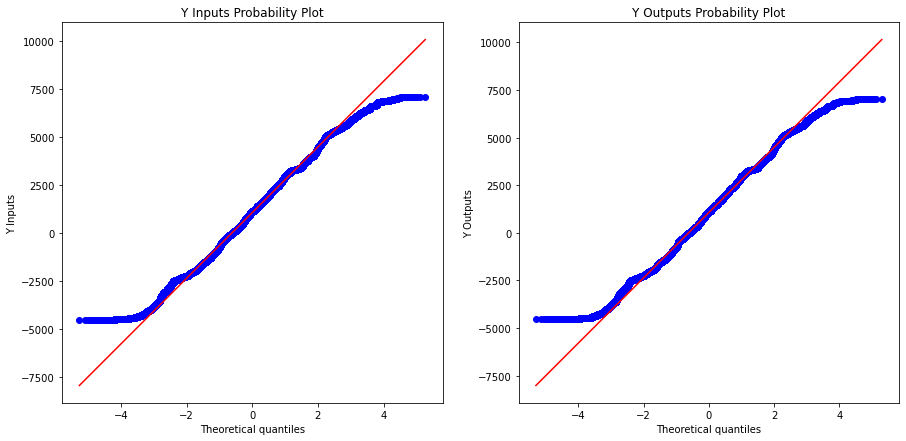

In [10]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 7))

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(y_in, dist="norm", plot=axs[0])
axs[0].set_ylabel('Y Inputs')
axs[0].set_title('Y Inputs Probability Plot')

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(y_out, dist="norm", plot=axs[1])
axs[1].set_ylabel('Y Outputs')
axs[1].set_title('Y Outputs Probability Plot')

fig.show()

In [49]:
dists = [((x_in[i-1]-x_in[i-50])**2 + (y_in[i-1]-y_in[i-50])**2)**0.5 for i in range(50, len(x_in), 50)]
dists

[0.05073417522137466,
 60.8536987303391,
 25.134911131402216,
 43.36582030939103,
 44.469898001276604,
 58.60417667665733,
 9.427502798597773,
 10.690069285167546,
 17.407492617195697,
 18.900697249108322,
 52.946797344099025,
 42.7693371297965,
 60.73721030289306,
 61.02205308104925,
 57.887299899217034,
 1.581093511314829,
 14.545564353458166,
 62.738775865394004,
 3.9804281884609423,
 58.236350968108155,
 0.1722382486477395,
 5.857248677790498,
 64.85951663574082,
 78.91214871330375,
 31.889839176886486,
 72.07766364289915,
 0.022060630484903473,
 71.81888665302952,
 69.39582453644391,
 42.36107336520947,
 45.44939831234928,
 25.316152152644126,
 70.3133289919222,
 26.618395279048077,
 77.6074175868738,
 36.049117419587056,
 60.049913976622165,
 35.45216653647758,
 49.19748444397225,
 5.277681449700421,
 0.008833777312276012,
 23.38966069715027,
 35.067712832163984,
 45.64038093676042,
 49.71703473105588,
 4.338319718477116,
 53.745519821321714,
 24.70649285496644,
 67.6345440254524

(array([2.14359653e-04, 1.68045054e-04, 8.06530473e-05, 5.82923498e-05,
        1.41416336e-05, 1.19289168e-05, 5.97685967e-06, 5.82082417e-06,
        2.38368892e-06, 7.89271767e-08]),
 array([1.04683582e-04, 1.78037025e+03, 3.56074039e+03, 5.34111053e+03,
        7.12148067e+03, 8.90185082e+03, 1.06822210e+04, 1.24625911e+04,
        1.42429612e+04, 1.60233314e+04, 1.78037015e+04]),
 <BarContainer object of 10 artists>)

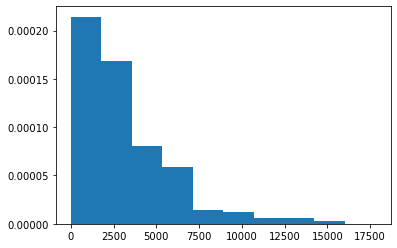

In [16]:
plt.hist(dists, density = True)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


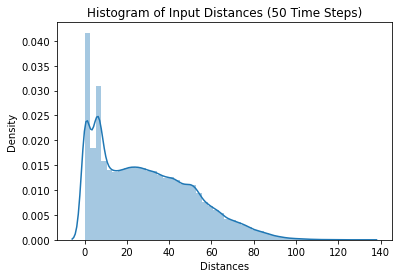

In [20]:
import seaborn as sns
sns.distplot(dists, kde = True).set(title='Histogram of Input Distances (50 Time Steps)', xlabel='Distances');

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Histogram of Input Speeds (50 Time Steps)'),
 Text(0.5, 0, 'Speed (Units Per Second)')]

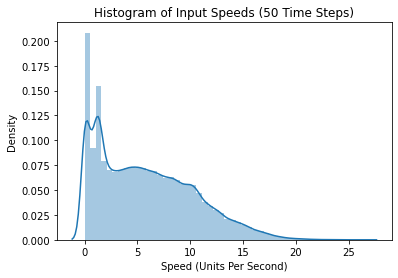

In [51]:
time = 5
s = [dists[i]/time for i in range(len(dists))]
sns.distplot(s, kde = True).set(title='Histogram of Input Speeds (50 Time Steps)', xlabel='Speed (Units Per Second)')

In [33]:
def centeroidnp(x, y):
    lengthx = len(x)
    lengthy = len(y)
    sum_x = sum(x)
    sum_y = sum(y)
    return [sum_x/lengthx, sum_y/lengthy]


In [166]:
centroids = [centeroidnp(x_in[i-50:i],y_in[i-50:i]) for i in range(50, len(x_in), 50)]
x_vals_in = [centroids[i][0] for i in range(len(centroids))]
y_vals_in = [centroids[i][1] for i in range(len(centroids))]

In [167]:
centroids = [centeroidnp(x_out[i-60:i],y_out[i-60:i]) for i in range(60, len(x_out), 60)]
x_vals_out = [centroids[i][0] for i in range(len(centroids))]
y_vals_out = [centroids[i][1] for i in range(len(centroids))]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


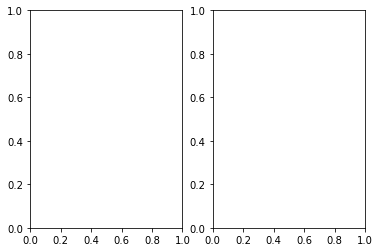

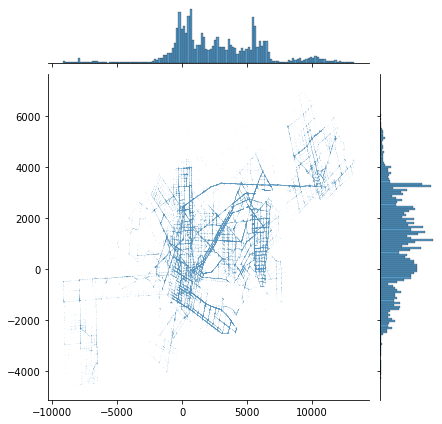

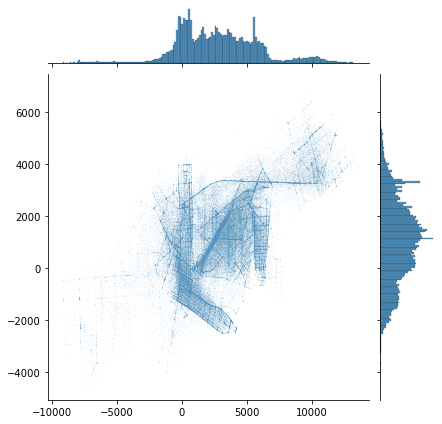

In [79]:
# import matplotlib.pyplot as plt

# f, axes = plt.subplots(1, 2)
# f.axes[0] = sns.jointplot(x_vals_in, y_vals_in, s=0.05)
# f.axes[1] = sns.jointplot(x_vals_out, y_vals_out, s=0.05)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


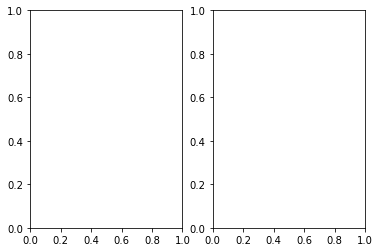

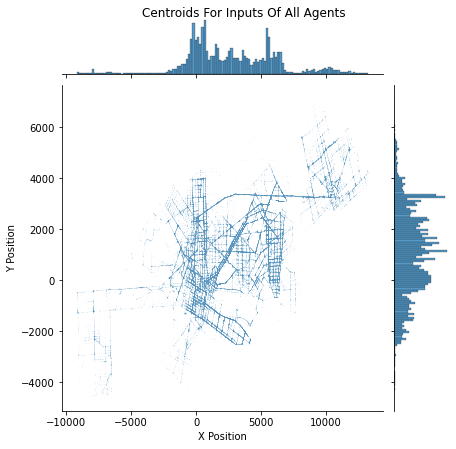

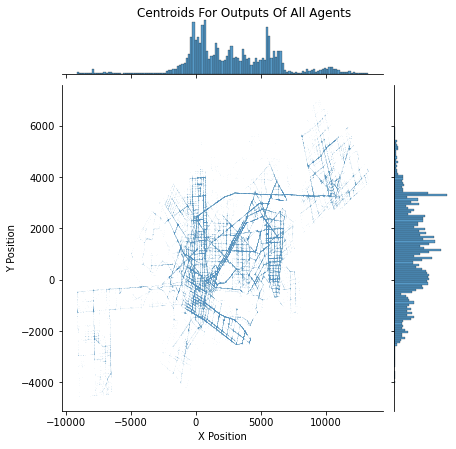

In [168]:
g, axes = plt.subplots(1, 2)

g = sns.jointplot(x_vals_in, y_vals_in, s=0.05, ax = axes[0])
g.fig.suptitle("Centroids For Inputs Of All Agents", y=1.0)
g.set_axis_labels('X Position', 'Y Position')

g = sns.jointplot(x_vals_out, y_vals_out, s=0.05, ax = axes[0])
g.fig.suptitle("Centroids For Outputs Of All Agents", y=1.0)
g.set_axis_labels('X Position', 'Y Position')
#g.set_title('Centroids For Inputs For All Agents')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


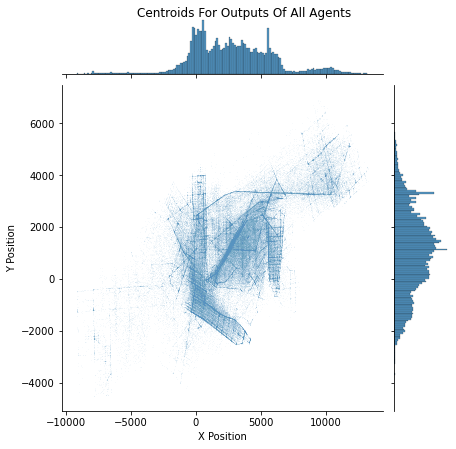

In [118]:
g = sns.jointplot(x_vals_out, y_vals_out, s=0.05)
g.fig.suptitle("Centroids For Outputs Of All Agents", y=1.0)
g.set_axis_labels('X Position', 'Y Position')


In [191]:
len(y_in)

10190800

In [199]:
v_x = [(x_in[i-1] - x_in[i-50])/50 *10 for i in range(50, len(x_in), 50)]
v_y = [(y_in[i-1] - y_in[i-50])/50 *10 for i in range(50, len(y_in), 50)]




203815

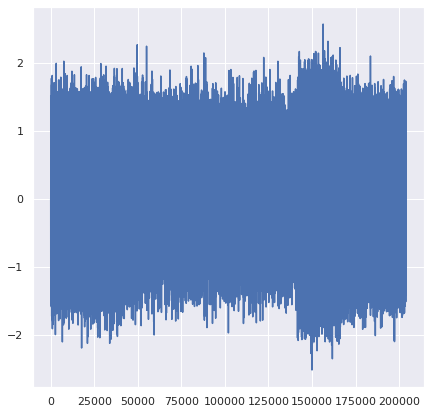

In [200]:
v_y = [(y_in[i-1] - y_in[i-50])/50 for i in range(50, len(y_in), 50)]
len(v_y)

plt.plot(v_x)

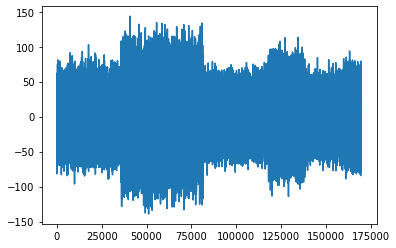

In [187]:
plt.plot(v_y)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


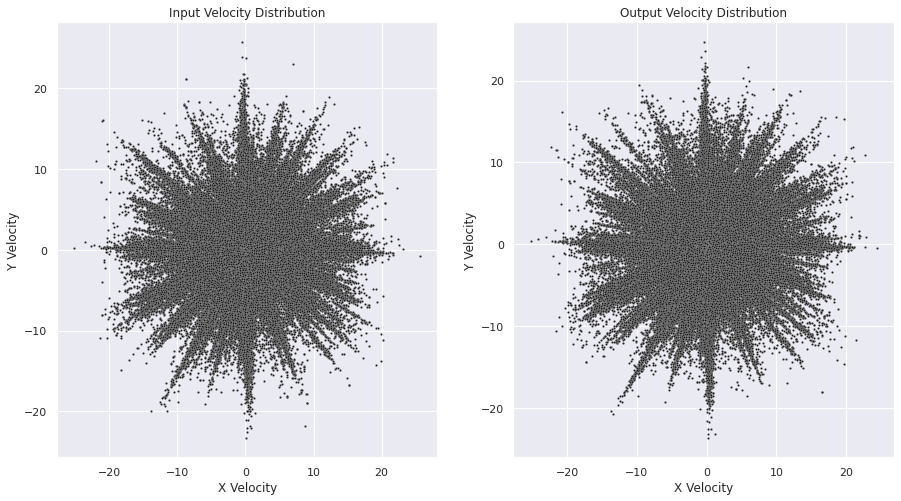

In [222]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 8))

v_x = [(x_in[i-1] - x_in[i-50])/50 *10 for i in range(50, len(x_in), 50)]
v_y = [(y_in[i-1] - y_in[i-50])/50 *10 for i in range(50, len(y_in), 50)]

sns.scatterplot(v_x, v_y, color = 'k', s =5, ax = axs[0]).set(title = 'Input Velocity Distribution', xlabel = 'X Velocity',ylabel = 'Y Velocity')

v_y = [(y_out[i-1] - y_out[i-60])/60 * 10 for i in range(60, len(y_out), 60)]
v_x = [(x_out[i-1] - x_out[i-60])/60 * 10 for i in range(60, len(x_out), 60)]
sns.scatterplot(v_x, v_y, color = 'k', s =5, ax = axs[1]).set(title = 'Output Velocity Distribution', xlabel = 'X Velocity',ylabel = 'Y Velocity')

fig.show()

In [213]:
v_y = [(y_out[i-1] - y_out[i-60])/60 * 10 for i in range(60, len(y_out), 60)]
v_x = [(x_out[i-1] - x_out[i-60])/60 * 10 for i in range(60, len(x_out), 60)]
len(v_x)

203815

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Output Velocity Distribution'),
 Text(0.5, 0, 'X Velocity'),
 Text(0, 0.5, 'Y Velocity')]

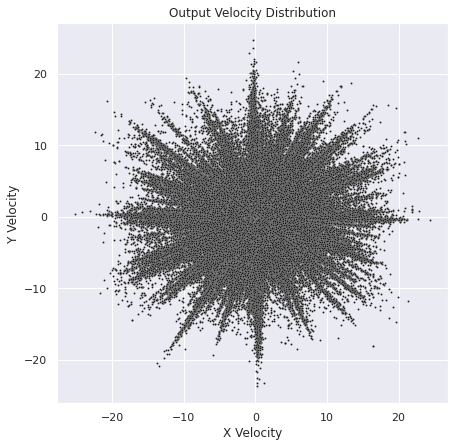

In [216]:
sns.set(rc={'figure.figsize':(7,7)})
sns.scatterplot(v_x, v_y, color = 'k', s =4).set(title = 'Output Velocity Distribution', xlabel = 'X Velocity',ylabel = 'Y Velocity')

